[View in Colaboratory](https://colab.research.google.com/github/sdevika/MLBootCamp/blob/master/lab3_partA.ipynb)

## Kernel Ridge Regression and Support Vector Regression
Both kernel ridge regression (KRR) and SVR learn a non-linear function by employing the kernel trick, i.e., they learn a linear function in the space induced by the respective kernel which corresponds to a non-linear function in the original space. They differ in the loss functions (ridge versus epsilon-insensitive loss). In contrast to SVR, fitting a KRR can be done in closed-form and is typically faster for medium-sized datasets. On the other hand, the learned model is non-sparse and thus slower than SVR at prediction-time.

This example illustrates both methods on an artificial dataset, which consists of a sinusoidal target function and strong noise added to every fifth datapoint. We compare the learned model of KRR and SVR when both complexity/regularization and bandwidth of the RBF kernel are optimized using grid-search. The learned functions are very similar; however, fitting KRR is approx. seven times faster than fitting SVR (both with grid-search). However, prediction of 100000 target values is more than tree times faster with SVR since it has learned a sparse model using only approx. 1/3 of the 100 training datapoints as support vectors.
Fitting KRR is faster than SVR for medium- sized training sets (less than 1000 samples); however, for larger training sets SVR scales better. With regard to prediction time, SVR is faster than KRR for all sizes of the training set because of the learned sparse solution. Note that the degree of sparsity and thus the prediction time depends on the parameters epsilon and C of the SVR.

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Import all needed packages

In [2]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD 3 clause


from __future__ import division
import time

import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

### Generate training data

In [3]:
rng = np.random.RandomState(0)

X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(int(X.shape[0]/5)))

X_plot = np.linspace(0, 5, 100000)[:, None]

### Fit regression models

In [4]:
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)

sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], kr_predict))

SVR complexity and bandwidth selected and model fitted in 0.978 s
KRR complexity and bandwidth selected and model fitted in 0.818 s
Support vector ratio: 0.310
SVR prediction for 100000 inputs in 0.070 s
KRR prediction for 100000 inputs in 0.334 s


### Visualize results

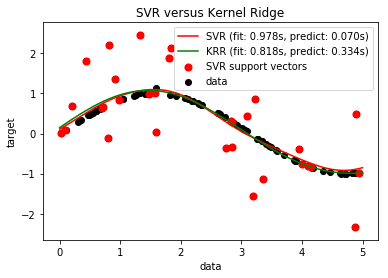

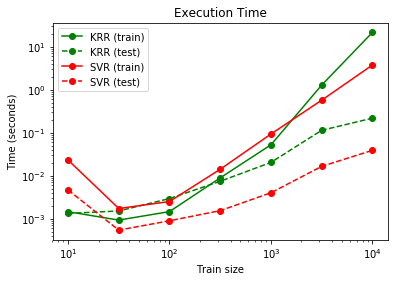

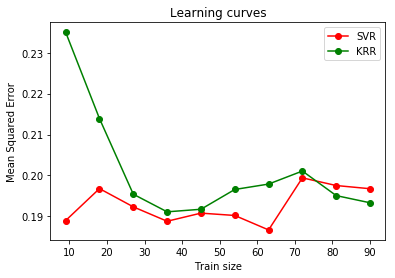

In [5]:
sv_ind = svr.best_estimator_.support_
plt.scatter(X[sv_ind], y[sv_ind], c='r', s=50, label='SVR support vectors',
            zorder=2)
plt.scatter(X[:100], y[:100], c='k', label='data', zorder=1)
#plt.hold('on')
plt.plot(X_plot, y_svr, c='r',
         label='SVR (fit: %.3fs, predict: %.3fs)' % (svr_fit, svr_predict))
plt.plot(X_plot, y_kr, c='g',
         label='KRR (fit: %.3fs, predict: %.3fs)' % (kr_fit, kr_predict))
plt.xlabel('data')
plt.ylabel('target')
plt.title('SVR versus Kernel Ridge')
plt.legend()

# Visualize training and prediction time
plt.figure()

# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(int(X.shape[0]/5)))
sizes = np.logspace(1, 4, 7)
for name, estimator in {"KRR": KernelRidge(kernel='rbf', alpha=0.1,
                                           gamma=10),
                        "SVR": SVR(kernel='rbf', C=1e1, gamma=10)}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:int(train_test_size)], y[:int(train_test_size)])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(sizes, train_time, 'o-', color="r" if name == "SVR" else "g",
             label="%s (train)" % name)
    plt.plot(sizes, test_time, 'o--', color="r" if name == "SVR" else "g",
             label="%s (test)" % name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title('Execution Time')
plt.legend(loc="best")

# Visualize learning curves
plt.figure()

svr = SVR(kernel='rbf', C=1e1, gamma=0.1)
kr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.1)
train_sizes, train_scores_svr, test_scores_svr = \
    learning_curve(svr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)
train_sizes_abs, train_scores_kr, test_scores_kr = \
    learning_curve(kr, X[:100], y[:100], train_sizes=np.linspace(0.1, 1, 10),
                   scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_svr.mean(1), 'o-', color="r",
         label="SVR")
plt.plot(train_sizes, -test_scores_kr.mean(1), 'o-', color="g",
         label="KRR")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves')
plt.legend(loc="best")
